## Consignas del desafío 4

Construir un traductor inglés-español.

---

## Desarrollo

### 1. Obtención del Dataset

Para entrenar un traductor basado en un modelo LSTM se necesita primero un dataset como el que provee la cátedra: [Anki](https://www.manythings.org/anki/).
Este dataset se compone de 118964 expresiones distintas escritas en inglés seguido de su traducción en español. La propia página de referencia indica que la estructura sigue un formato `English + TAB + The Other Language`.

In [1]:
from collections import Counter

text_file = "./spa.txt"

# Leer archivo línea por línea y separar inglés y español
pairs = []
with open(text_file, encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # saltar líneas vacías
        if '\t' not in line:
            continue  # saltar líneas sin tab
        en, es = line.split('\t')[:2]  # tomar solo los dos primeros campos
        pairs.append({'en': en, 'es': es})

# Ahora cada elemento es un diccionario, podemos hacer .keys()
print("Campos disponibles en el primer ejemplo:", pairs[0].keys())

# Inicializar contadores
field_lengths = Counter()
num_empty = Counter()
num_examples = len(pairs)

# Revisar primeros 2 ejemplos
print("\nPrimeros 2 ejemplos (campos y longitudes en palabras):")
for i, sample in enumerate(pairs[:2]):
    print(f"\nEjemplo {i+1}:")
    for k, v in sample.items():
        print(f"  {k}: {len(v.split())} palabras")
        if len(v.strip()) == 0:
            num_empty[k] += 1
        field_lengths[k] += len(v.split())

# Estadísticas generales
print("\n--- Estadísticas del dataset ---")
print(f"Número total de ejemplos: {num_examples}")
print("Número de ejemplos con campos vacíos:")
for k, count in num_empty.items():
    print(f"  {k}: {count} ({count/num_examples*100:.2f}%)")

Campos disponibles en el primer ejemplo: dict_keys(['en', 'es'])

Primeros 2 ejemplos (campos y longitudes en palabras):

Ejemplo 1:
  en: 1 palabras
  es: 1 palabras

Ejemplo 2:
  en: 1 palabras
  es: 1 palabras

--- Estadísticas del dataset ---
Número total de ejemplos: 118964
Número de ejemplos con campos vacíos:


### 2. Preprocesamiento

Los datos crudos deben ser preprocesados y normalizados para facilitar la posterior tokenización del vocabulario. Para ello, se procesa el texto de muestra para:

1. Escribir todo el texto en letra minúscula, normalizar los espacios entre palabras y eliminar caracteres especiales.
2. Añadir tokens especiales
3. Limitar la longitud de las estructuras encoder/decoder
4. Filtrar ejemplos vacíos o muy largos

Para entrenar luego el modelo encoder-decoder, se prepara el dataset de modo que la entrada de ejemplo del encoder sea la expresión en inglés y como target de salida del decoder la traducción de esa expresión al español.

In [2]:
import json
import re
import pickle
import collections
import os

# ------------------------
# Configuración
# ------------------------
TEXT_FILE = "spa.txt"
OUTPUT_DIR = "traductor"
MAX_LEN_ENCODER = 128
MAX_LEN_DECODER = 64
MIN_FREQ = 3
VOCAB_SIZE = 30000

SPECIAL_TOKENS = {
    "pad": "<pad>",
    "unk": "<unk>",
    "sos": "<sos>",
    "eos": "<eos>",
    "sep": "<sep>",
}

# ------------------------
# Normalización básica
# ------------------------
def normalize_text(s):
    s = s.lower()
    s = re.sub(r"[^a-zA-Z0-9áéíóúüñ!?.,' ]+", " ", s)  # mantener acentos y símbolos comunes
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ------------------------
# Construcción dataset
# ------------------------
def build_examples(data):
    """
    Convierte lista de diccionarios {'en': ..., 'es': ...}
    en pares (encoder_input, decoder_target) normalizados.
    """
    examples = []
    for sample in data:
        en_text = sample.get("en", "").strip()
        es_text = sample.get("es", "").strip()
        if not en_text or not es_text:
            continue

        # normalizar
        en_text_norm = normalize_text(en_text)
        es_text_norm = normalize_text(es_text)

        examples.append({
            "encoder_text": en_text_norm,
            "decoder_text": es_text_norm
        })

    return examples

# Construir pares encoder-decoder
examples = build_examples(pairs)

# Revisar algunos ejemplos
print("Primeros 3 pares encoder-decoder:")
for ex in examples[:3]:
    print(f"EN: {ex['encoder_text']}")
    print(f"ES: {ex['decoder_text']}\n")

Primeros 3 pares encoder-decoder:
EN: go.
ES: ve.

EN: go.
ES: vete.

EN: go.
ES: vaya.



### 3. Tokenización

Tras limpiar el contenido de las conversaciones, normalizar el texto y separar las entradas y salidas del encoder y del decoder, se continúa con la tokenización del texto y la generación de diccionarios para trabajar con secuencias más aptas para el uso de modelos. Para un manejo del lenguaje más robusto y naturalizado, así como para evitar `<unk>`, se tokeniza el corpus utilizando la librería *spaCy* como se muestra a continuación:

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

import spacy

# ------------------------
# Cargar modelo spaCy
# ------------------------
# Descargar modelo si no lo tenés:
# python -m spacy download en_core_web_sm
nlp_en = spacy.load("en_core_web_sm")
nlp_es = spacy.load("es_core_news_sm")


# ------------------------
# Tokenización con spaCy
# ------------------------
def tokenize_en(text):
    """
    Tokeniza un texto usando spaCy.
    Devuelve una lista de tokens limpios.
    Compatible con embeddings FastText.
    """
    doc = nlp_en(text)
    tokens = [token.text.lower() for token in doc if not token.is_space]
    return tokens

def tokenize_es(text):
    """
    Tokeniza un texto usando spaCy.
    Devuelve una lista de tokens limpios.
    Compatible con embeddings FastText.
    """
    doc = nlp_es(text)
    tokens = [token.text.lower() for token in doc if not token.is_space]
    return tokens

def build_vocab(examples):
    counter = collections.Counter()
    for ex in examples:
        counter.update(tokenize_en(ex["encoder_text"]))
        counter.update(tokenize_es(ex["decoder_text"]))

    # aplicar min_freq
    tokens = [tok for tok, c in counter.items() if c >= MIN_FREQ]
    tokens = tokens[:VOCAB_SIZE - len(SPECIAL_TOKENS)]

    vocab = list(SPECIAL_TOKENS.values()) + tokens
    token2id = {tok: i for i, tok in enumerate(vocab)}
    id2token = {i: tok for tok, i in token2id.items()}
    return token2id, id2token

def numericalize(tokens, token2id, max_len, is_decoder=False):
    ids = []
    if is_decoder:
        ids.append(token2id[SPECIAL_TOKENS["sos"]])
    for t in tokens:
        ids.append(token2id.get(t, token2id[SPECIAL_TOKENS["unk"]]))
    if is_decoder:
        ids.append(token2id[SPECIAL_TOKENS["eos"]])

    length = len(ids)
    ids = ids[:max_len]

    while len(ids) < max_len:
        ids.append(token2id[SPECIAL_TOKENS["pad"]])

    return ids, min(length, max_len)

# Vocabulario
token2id, id2token = build_vocab(examples)

processed = []
for ex in examples:
    enc_tokens = tokenize_en(ex["encoder_text"])
    dec_tokens = tokenize_es(ex["decoder_text"])

    enc_ids, enc_len = numericalize(enc_tokens, token2id, MAX_LEN_ENCODER)
    dec_ids, dec_len = numericalize(dec_tokens, token2id, MAX_LEN_DECODER, is_decoder=True)

    processed.append({
        "encoder_ids": enc_ids,
        "encoder_len": enc_len,
        "decoder_ids": dec_ids,
        "decoder_len": dec_len
    })

# Guardar
os.makedirs(OUTPUT_DIR, exist_ok=True)
with open(f"{OUTPUT_DIR}/token2id.pkl", "wb") as f:
    pickle.dump(token2id, f)
with open(f"{OUTPUT_DIR}/id2token.pkl", "wb") as f:
    pickle.dump(id2token, f)
with open(f"{OUTPUT_DIR}/dataset.pkl", "wb") as f:
    pickle.dump(processed, f)

stats = {
    "num_examples": len(processed),
    "vocab_size": len(token2id),
    "max_len_encoder": MAX_LEN_ENCODER,
    "max_len_decoder": MAX_LEN_DECODER,
}
with open(f"{OUTPUT_DIR}/stats.json", "w") as f:
    json.dump(stats, f, indent=2)

def tokenizer(text):
    return [tok.text.lower() for tok in nlp(text) if not tok.is_space]

print("✅ Preprocesamiento completo")
print(stats)

✅ Preprocesamiento completo
{'num_examples': 118964, 'vocab_size': 17982, 'max_len_encoder': 128, 'max_len_decoder': 64}


### 4. Embeddings

Con los diccionarios de vocabulario ya creados, se codifican embeddings usando estos tokens como base y con ayuda del módulo `gensim.Fastext` de *Gensim*, que se elige por su robustez y capacidad de adaptación frente a palabras por fuera del vocabulario de muestra, lo cual es probable que ocurra en un bot conversacional.

In [4]:
from gensim.models import FastText

# Extraer todas las frases tokenizadas del dataset
all_sentences = []

for ex in processed:  # processed = lista de diccionarios con 'encoder_ids' y 'decoder_ids'
    enc_tokens = [id2token[i] for i in ex['encoder_ids'] if i != token2id['<pad>']]
    dec_tokens = [id2token[i] for i in ex['decoder_ids'] if i != token2id['<pad>']]
    
    all_sentences.append(enc_tokens)
    all_sentences.append(dec_tokens)


# Entrenar FastText
ft_model = FastText(
    sentences=all_sentences,
    vector_size=100,   # dimensión de los embeddings
    window=5,          # contexto
    min_count=1,       # ya tenemos vocab, poner 1 para incluir todos los tokens
    sg=1,              # 1 = skip-gram, 0 = CBOW
    workers=4,
    epochs=10
)

# Guardar modelo
ft_model.save("fasttext_convai2.model")


Con el embedding ya creado, se traducen todos los tensores tokenizados a tensores con los embeddings que ha encontrado FastText, que serán los tensores con los que se alimenta el modelo.

In [5]:
import torch
import numpy as np
import torch.nn as nn

vocab_size = len(token2id)
embedding_dim = ft_model.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for token, idx in token2id.items():
    if token in ft_model.wv:
        embedding_matrix[idx] = ft_model.wv[token]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))  # fallback

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
print(embedding_matrix.shape)  # (vocab_size, embedding_dim)

embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)


torch.Size([17982, 100])


### 5. Dataloaders

Para entrenar el modelo encoder-decoder se facilita la ingesta de datos a través del armado de un Dataloader. Este dataloader debe devolver tensores `encoder_input` y `decoder_input` para el consumo de los datos y `decoder_target` como respuesta de validación con la que ajustar el modelo. Para ello, es necesario eliminar los tokens `<eos>` y `<sos>` en la entrada y salida del decoder, respectivamente; de modo que las listas de entrenamiento sean del mismo tamaño pero con un desfasaje entre ellas.

In [6]:
import torch
from torch.utils.data import Dataset

class BotDataset(Dataset):
    def __init__(self, data, pad_idx):
        self.data = data
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]
        enc = ex["encoder_ids"]
        dec = ex["decoder_ids"]

        # Entrada al decoder: sin el último token (<eos>)
        dec_input = dec[:-1]
        # Target del decoder: sin el primero (<sos>)
        dec_target = dec[1:]

        return torch.tensor(enc, dtype=torch.long), torch.tensor(dec_input, dtype=torch.long), torch.tensor(dec_target, dtype=torch.long)


Como las secuencias tienen longitudes variables, se requiere construir un padding dinámico que llene los espacios vacíos cuando sea necesario. Esto se traduce en una *collate function* personalizada que permita hacer esto en la construcción de secuencias del Dataloader. La función de padding es un asset más que se utiliza directamente desde PyTorch:

In [7]:
from torch.nn.utils.rnn import pad_sequence

PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
PAD_IDX = token2id[PAD_TOKEN]
SOS_IDX = token2id[SOS_TOKEN]
EOS_IDX = token2id[EOS_TOKEN]

def collate_fn(batch):
    encoders, dec_inputs, dec_targets = zip(*batch)
    
    enc_padded = pad_sequence(encoders, batch_first=True, padding_value=PAD_IDX)
    dec_in_padded = pad_sequence(dec_inputs, batch_first=True, padding_value=PAD_IDX)
    dec_tgt_padded = pad_sequence(dec_targets, batch_first=True, padding_value=PAD_IDX)

    return enc_padded, dec_in_padded, dec_tgt_padded


Habiendo creado estas estructuras, se genera el dataloader que tome como base los embeddings preparados, separando previamente el mismo en conjuntos de entrenamiento y validación:

In [8]:
from torch.utils.data import DataLoader, random_split

dataset = BotDataset(processed, PAD_IDX)

# train-val split: 80/20 split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)


### 6. Estructura del modelo

Con todos los datos de alimentación y comparación preparados, solo resta crear la estructura del modelo y entrenarlo. El modelo *seq2seq* consiste en un modelo many-to-many que traduce una secuencia de un tensor a otro, pero procesando todo el tensor de entrada a la vez y considerando la relación y orden de los elementos del tensor y no solo la aparición o no de los mismos. El mecanismo que produce esta transformación se basa en una arquitectura encoder-decoder, donde el segundo trata de recrear el mapeo que realiza el primero sobre la información de entrada para entender mejor el contexto de escritura en el que se trabaja para poder brindar una salida de mejor calidad.

Como se mencionó antes, el orden de los elementos del tensor es relevante para poder obtener una mejor salida, por lo que la utilización de capas LSTM resulta de gran ayuda en la obtención de una salida de calidad.

Se destaca que en lugar de entrenar la capa de embeddings desde cero como en un modelo normal, se importa la capa de embeddings ya generada con FastText para la codificación de los elementos.

In [9]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, embedding, hidden_size, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = embedding
        self.lstm = nn.LSTM(
            embedding.embedding_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, (hidden, cell)

Para el decodificador se incorpora además un mecanismo de atención que permita al modelo tener más presente el contexto general de la conversación y no solo depender de la última información recibida. Vale la pena mencionar que se escoge una técnica de atención conocido como **[Atención Bahdanau](https://medium.com/@abhishekjainindore24/everything-about-attention-mechanism-bahdanau-attention-and-luong-attention-f76e63b702ca)**, que permite también destacar los tokens que más información aportan al contexto de la conversación que se está teniendo.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [batch, dec_hidden_dim]
        # encoder_outputs: [batch, src_len, enc_hidden_dim]
        src_len = encoder_outputs.shape[1]

        # Repetir hidden para cada paso de la secuencia
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch, src_len, dec_hidden_dim]
        attention = self.v(energy).squeeze(2)  # [batch, src_len]

        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention, dim=1)
    
class Decoder(nn.Module):
    def __init__(self, embedding, enc_hidden_dim, dec_hidden_dim, output_dim, attention, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = embedding
        self.attention = attention
        self.lstm = nn.LSTM(
            embedding.embedding_dim + enc_hidden_dim,
            dec_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + embedding.embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs, mask=None):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))  # [batch, 1, emb_dim]

        attn_weights = self.attention(hidden[-1], encoder_outputs, mask).unsqueeze(1)  # [batch, 1, src_len]
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, enc_hidden_dim]

        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        # Salida final
        output_pred = self.fc_out(torch.cat((output, context, embedded), dim=2).squeeze(1))
        return output_pred, hidden, cell, attn_weights.squeeze(1)

La estructura del modelo completo seq2seq queda definido entonces como:

In [11]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device

    def create_mask(self, src):
        return (src != self.pad_idx).to(self.device)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        encoder_outputs, (hidden, cell) = self.encoder(src)
        mask = self.create_mask(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs, mask)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs

### 7. Entrenamiento del modelo

Con la estructura y los datos ya preparados, solo queda definir una función de entrenamiento para configurar el modelo. El uso de GPU acelera mucho el procesamiento de los datos para poder entrenarlo con el vocabulario entero.

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, dataloader, optimizer, criterion, device, clip=1.0):
    model.train()
    epoch_loss = 0

    for batch in tqdm(dataloader, desc="Entrenando", leave=False):
        src, trg_in, trg_out = [x.to(device) for x in batch]

        optimizer.zero_grad()
        output = model(src, trg_in)  # [batch, trg_len, vocab_size]

        # Ignorar el primer token (<sos>)
        loss = criterion(output.view(-1, output.shape[-1]), trg_out.view(-1))
        loss.backward()

        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0

    for batch in tqdm(dataloader, desc="Validando", leave=False):
        src, trg_in, trg_out = [x.to(device) for x in batch]
        with torch.no_grad():
            output = model(src, trg_in)
            loss = criterion(output.view(-1, output.shape[-1]), trg_out.view(-1))
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def train_model(model, train_loader, val_loader, optimizer, criterion, device, n_epochs=10, clip=1.0):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, clip)
        val_loss = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Curvas de pérdida ----
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title("Curvas de pérdida")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses

Por último, se inicializan todas las estructuras del modelo y se usa la función de entrenamiento:

Usando dispositivo: cuda


Epoch 1/20 | Train Loss: 4.7500 | Val Loss: 3.8394


Epoch 2/20 | Train Loss: 3.4695 | Val Loss: 3.4110


Epoch 3/20 | Train Loss: 3.0452 | Val Loss: 3.2220


Epoch 4/20 | Train Loss: 2.8028 | Val Loss: 3.1623


Epoch 5/20 | Train Loss: 2.6382 | Val Loss: 3.1581


Epoch 6/20 | Train Loss: 2.5114 | Val Loss: 3.1510


Epoch 7/20 | Train Loss: 2.4156 | Val Loss: 3.1664


Epoch 8/20 | Train Loss: 2.3361 | Val Loss: 3.1994


Epoch 9/20 | Train Loss: 2.2683 | Val Loss: 3.2248


Epoch 10/20 | Train Loss: 2.2115 | Val Loss: 3.2479


Epoch 11/20 | Train Loss: 2.1643 | Val Loss: 3.2919


Epoch 12/20 | Train Loss: 2.1191 | Val Loss: 3.3413


Epoch 13/20 | Train Loss: 2.0801 | Val Loss: 3.3620


Epoch 14/20 | Train Loss: 2.0494 | Val Loss: 3.4048


Epoch 15/20 | Train Loss: 2.0154 | Val Loss: 3.4439


Epoch 16/20 | Train Loss: 1.9875 | Val Loss: 3.4753


Epoch 17/20 | Train Loss: 1.9617 | Val Loss: 3.5241


Epoch 18/20 | Train Loss: 1.9412 | Val Loss: 3.5470


Epoch 19/20 | Train Loss: 1.9220 | Val Loss: 3.5726


Epoch 20/20 | Train Loss: 1.9022 | Val Loss: 3.6107


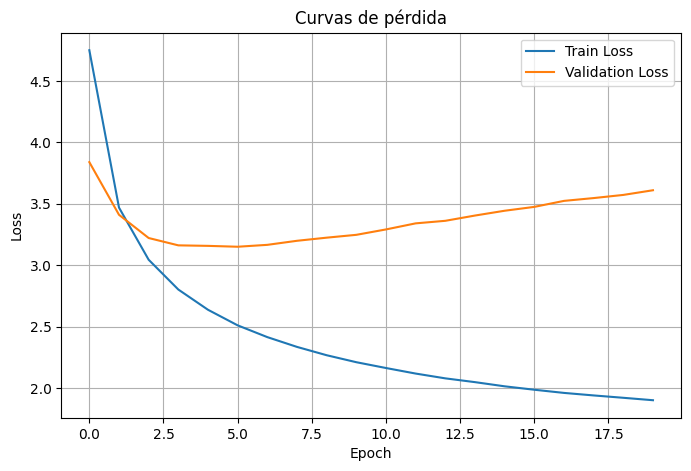

In [13]:
INPUT_DIM = len(token2id)
OUTPUT_DIM = len(token2id)
HIDDEN_SIZE = 256
NUM_LAYERS = 1
DROPOUT = 0.3
LR = 1e-3
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", DEVICE)

attn = Attention(HIDDEN_SIZE, HIDDEN_SIZE)
encoder = Encoder(embedding_layer, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
decoder = Decoder(embedding_layer, HIDDEN_SIZE, HIDDEN_SIZE, OUTPUT_DIM, attn, NUM_LAYERS, DROPOUT)

model = Seq2SeqModel(encoder, decoder, PAD_IDX, DEVICE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    DEVICE,
    n_epochs=EPOCHS,
    clip=1.0
)

torch.save(model.state_dict(), "seq2seq_model.pth")

### 8. Inferencia

Con el modelo ya entrenado, se puede utilizar el mismo para inferir nuevas respuestas. Para generalizar un poco más las respuestas se usa un algoritmo *beam search* para entregar la frase de salida en lugar de una búsqueda *greedy* que puede llevar a "alucinaciones" en la respuesta.

In [17]:
import torch
import torch.nn.functional as F

def beam_search(model, src_tensor, src_len, vocab, beam_width=3, max_len=20, device="cuda"):
    model.eval()
    with torch.no_grad():
        src_tensor = src_tensor.unsqueeze(0).to(device)
        src_len = torch.tensor([src_len]).to(device)

        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
        
        # Inicializamos el haz con el token <SOS>
        beams = [(torch.tensor([[vocab["<sos>"]]]).to(device), hidden, 0)]  # (seq, hidden, score)

        for _ in range(max_len):
            new_beams = []
            for seq, hidden, score in beams:
                last_token = seq[-1, -1].unsqueeze(0)

                if last_token.item() == vocab["<eos>"]:
                    new_beams.append((seq, hidden, score))
                    continue

                output, hidden, cell, attn_weights = model.decoder(
                    last_token, hidden, cell, encoder_outputs
                )
                log_probs = F.log_softmax(output, dim=1)

                # Penalizar tokens desconocido en la respuesta
                log_probs[:, vocab["<unk>"]] -= 10.0

                # Expandimos los beam candidates
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)

                for k in range(beam_width):
                    next_token = topk_indices[0][k].unsqueeze(0).unsqueeze(0)
                    next_seq = torch.cat([seq, next_token], dim=1)
                    next_score = score + topk_log_probs[0][k].item()
                    new_beams.append((next_seq, hidden, next_score))

            # Ordenamos y mantenemos los mejores beam_width candidatos
            beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_width]

        # Retorna la mejor secuencia (la de mayor score)
        best_seq = beams[0][0].squeeze().tolist()
        return best_seq

input_text = "These mosquitoes are bugging me off"
tokens = [token2id.get(tok, token2id["<unk>"]) for tok in input_text.split()]
indices = [token2id.get(t, token2id["<unk>"]) for t in tokens]
src_tensor = torch.tensor(indices, dtype=torch.long)

predicted_ids = beam_search(model, src_tensor, len(indices), token2id, beam_width=10)
predicted_tokens = [id2token[i] for i in predicted_ids if i not in [token2id["<sos>"], token2id["<eos>"], token2id["<pad>"]]]

print("Respuesta generada:", " ".join(predicted_tokens))

Respuesta generada: reformas dinero a pasar de .
